In [157]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [158]:
import warnings
warnings.filterwarnings('ignore')

In [159]:
#dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [160]:
#raw_df = pd.read_csv(dataset)
_df_ = pd.read_csv('clean_df.csv')

In [161]:
_df_.describe()

Unnamed: 0     Latitude    Longitude  NumberofBuildings  \
count  1440.000000  1440.000000  1440.000000        1440.000000   
mean    728.482639    47.615850  -122.333765           1.112500   
std     421.522776     0.046946     0.023199           1.221129   
min       0.000000    47.509590  -122.411820           0.000000   
25%     362.750000    47.586950  -122.342740           1.000000   
50%     729.500000    47.612335  -122.333280           1.000000   
75%    1092.250000    47.648240  -122.323520           1.000000   
max    1465.000000    47.733870  -122.261800          27.000000   

       NumberofFloors  ENERGYSTARScore  PropertyGFABuilding(s)  \
count     1440.000000       967.000000            1.440000e+03   
mean         4.349306        63.749741            1.023572e+05   
std          6.759201        28.806512            1.770243e+05   
min          0.000000         1.000000            3.636000e+03   
25%          1.000000        44.000000            2.849800e+04   
50%          3.000000        71.000000            4.687900e+04   
75%          5.000000        88.000000            9.626550e+04   
max         99.000000       100.000000            2.200000e+06   

       PropertyGFAParking  LargestPropertyUseTypeGFA  SteamUse(kBtu)  \
count         1440.000000               1.436000e+03     1440.000000   
mean         14418.843056               9.455830e+04        0.067361   
std          44731.415406               1.629127e+05        0.250733   
min              0.000000               5.656000e+03        0.000000   
25%              0.000000               2.561000e+04        0.000000   
50%              0.000000               4.303300e+04        0.000000   
75%              0.000000               9.279725e+04        0.000000   
max         512608.000000               1.719643e+06        1.000000   

       Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
count        1440.000000       1440.000000        1440.000000   
mean            0.997917          0.712500         177.627243   
std             0.045612          0.452754         609.768933   
min             0.000000          0.000000          -0.800000   
25%             1.000000          0.000000          19.887500   
50%             1.000000          1.000000          49.040000   
75%             1.000000          1.000000         142.052500   
max             1.000000          1.000000       12307.160000   

       SiteEnergyUse(kBtu)  
count         1.440000e+03  
mean          8.002949e+06  
std           1.856069e+07  
min           5.713320e+04  
25%           1.240258e+06  
50%           2.695255e+06  
75%           7.267172e+06  
max           2.930908e+08

In [162]:
clean_df = _df_.drop(columns=['ENERGYSTARScore','Unnamed: 0']).copy()

In [163]:
clean_df.dropna(inplace=True)

In [164]:
clean_df.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [165]:
clean_df.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                     object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)                 int64
Electricity(kBtu)              int64
NaturalGas(kBtu)               int64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [166]:
clean_df

PrimaryPropertyType  Latitude  Longitude  YearBuilt  \
0                           Hotel  47.61220 -122.33799  1920_1940   
1                           Hotel  47.61317 -122.33393  1980_2000   
2                           Hotel  47.61393 -122.33810  1960_1980   
3                           Hotel  47.61412 -122.33664  1920_1940   
4                           Hotel  47.61375 -122.34047  1960_1980   
...                           ...       ...        ...        ...   
1435                    Warehouse  47.54425 -122.31776  1940_1960   
1436  Small- and Mid-Sized Office  47.53161 -122.29944  1920_1940   
1437                        Other  47.68109 -122.26180      2000_   
1438                  K-12 School  47.58831 -122.30650      2000_   
1439           Mixed Use Property  47.62497 -122.33883      2000_   

      NumberofBuildings  NumberofFloors  PropertyGFABuilding(s)  \
0                   1.0              12                   88434   
1                   1.0              11                   88502   
2                   1.0              41                  759392   
3                   1.0              10                   61320   
4                   1.0              18                  113580   
...                 ...             ...                     ...   
1435                1.0               1                   47863   
1436                1.0               2                   24990   
1437                1.0               1                   72000   
1438                1.0               3                   45000   
1439                1.0               6                  260262   

      PropertyGFAParking  LargestPropertyUseTypeGFA  SteamUse(kBtu)  \
0                      0                    88434.0               1   
1                  15064                    83880.0               0   
2                 196718                   756493.0               1   
3                      0                    61320.0               1   
4                  62000                   123445.0               0   
...                  ...                        ...             ...   
1435                4222                    52085.0               0   
1436                   0                    24990.0               0   
1437                   0                    72000.0               0   
1438                   0                    45728.0               0   
1439               85028                   151523.0               0   

      Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0                     1                 1             249.98   
1                     1                 1             295.86   
2                     1                 1            2089.28   
3                     1                 1             286.43   
4                     1                 1             505.01   
...                 ...               ...                ...   
1435                  1                 1             157.70   
1436                  1                 1             134.80   
1437                  1                 1              67.65   
1438                  1                 0               9.24   
1439                  1                 1            1000.06   

      SiteEnergyUse(kBtu)  
0              7226362.50  
1              8387933.00  
2             72587024.00  
3              6794584.00  
4             14172606.00  
...                   ...  
1435           3605855.50  
1436           4420650.50  
1437           2925780.00  
1438           1325972.75  
1439          39364116.00  

[1436 rows x 14 columns]

In [167]:
clean_df = clean_df.reset_index(drop=True)

Les deux features catégorielles doivent etre converti avant utilisation dans les modèles

In [168]:
df_encoded = pd.get_dummies(clean_df ,columns=['PrimaryPropertyType','YearBuilt'])

In [169]:
df_encoded

Latitude  Longitude  NumberofBuildings  NumberofFloors  \
0     47.61220 -122.33799                1.0              12   
1     47.61317 -122.33393                1.0              11   
2     47.61393 -122.33810                1.0              41   
3     47.61412 -122.33664                1.0              10   
4     47.61375 -122.34047                1.0              18   
...        ...        ...                ...             ...   
1431  47.54425 -122.31776                1.0               1   
1432  47.53161 -122.29944                1.0               2   
1433  47.68109 -122.26180                1.0               1   
1434  47.58831 -122.30650                1.0               3   
1435  47.62497 -122.33883                1.0               6   

      PropertyGFABuilding(s)  PropertyGFAParking  LargestPropertyUseTypeGFA  \
0                      88434                   0                    88434.0   
1                      88502               15064                    83880.0   
2                     759392              196718                   756493.0   
3                      61320                   0                    61320.0   
4                     113580               62000                   123445.0   
...                      ...                 ...                        ...   
1431                   47863                4222                    52085.0   
1432                   24990                   0                    24990.0   
1433                   72000                   0                    72000.0   
1434                   45000                   0                    45728.0   
1435                  260262               85028                   151523.0   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  ...  \
0                  1                  1                 1  ...   
1                  0                  1                 1  ...   
2                  1                  1                 1  ...   
3                  1                  1                 1  ...   
4                  0                  1                 1  ...   
...              ...                ...               ...  ...   
1431               0                  1                 1  ...   
1432               0                  1                 1  ...   
1433               0                  1                 1  ...   
1434               0                  1                 0  ...   
1435               0                  1                 1  ...   

      PrimaryPropertyType_Supermarket / Grocery Store  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
1431                                                0   
1432                                                0   
1433                                                0   
1434                                                0   
1435                                                0   

      PrimaryPropertyType_University  PrimaryPropertyType_Warehouse  \
0                                  0                              0   
1                                  0                              0   
2                                  0                              0   
3                                  0                              0   
4                                  0                              0   
...                              ...                            ...   
1431                               0                              1   
1432                               0                              0   
1433                               0                              0   
1434                               0                              0   
1435                         

In [170]:
features = df_encoded.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

In [171]:
features_names = features.columns

In [172]:
features_names

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehou

In [173]:
train, test = train_test_split(df_encoded, test_size=0.33, random_state=10) 

In [174]:
X1_train, y1_train, X1_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

## <a name='C2'> Prédictions de la consomation d'énergie   </a>

In [175]:
""" scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test) """

' scaler = StandardScaler()\nscaler.fit(X1_train)\nX1_train = scaler.transform(X1_train)\nX1_test = scaler.transform(X1_test) '

In [176]:
r_forest = RandomForestRegressor(random_state=0)

In [177]:
# entrainement du modèle
r_forest.fit(X1_train, y1_train)

RandomForestRegressor(random_state=0)

In [178]:
# prédiction
preds = r_forest.predict(X1_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

9019362.83635346


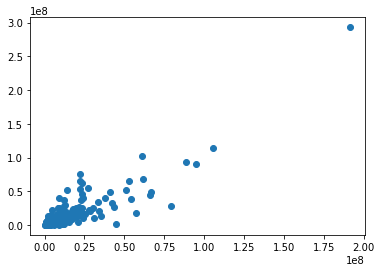

In [179]:
plt.scatter(preds,y1_test)

In [180]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=12)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [181]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X1_train, X1_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  9519169.648082  		 MAE: 3780422.925154  		 R2:  0.753262
N_Estimator: 200  		 RMSE:  9389052.966345  		 MAE: 3754488.401738  		 R2:  0.759961
N_Estimator: 300  		 RMSE:  9233086.205516  		 MAE: 3730179.878451  		 R2:  0.767870
N_Estimator: 400  		 RMSE:  9098566.157039  		 MAE: 3718101.193315  		 R2:  0.774584
N_Estimator: 500  		 RMSE:  8962671.319986  		 MAE: 3705451.243017  		 R2:  0.781268


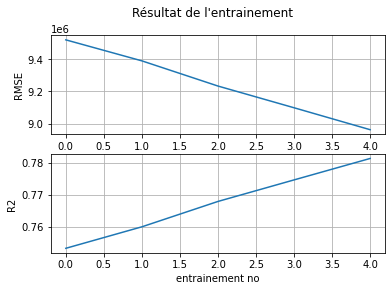

In [182]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

### <a name='C2'> GridSearch CV   </a>

In [183]:
def get_errors(y_test,y_pred):
    rmse = m_s_e(y_test, y_pred,squared=False)
    mae = m_a_e(y_test, y_pred)
    r_2 = r2(y_test,y_pred)
    mean_ = np.mean(y1_test)
    return (r_2, rmse, mae, mean_)

### - Dummy Regressor

In [184]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [185]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [186]:
CV_dummy_mean.best_score_

-0.019458249109060334

In [187]:
dummy_model = CV_dummy_mean.best_estimator_

In [188]:
dummy_model.score(X1_test,y1_test)

-0.0001254619300008475

In [189]:
print(f"Validation Score: {round(CV_dummy_mean.best_score_*100,2)} %")
print(f"Score - training data: {round(CV_dummy_mean.score(X1_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X1_test,y1_test)*100,2)} %")

Validation Score: -1.95 %
Score - training data: 0.0 %
Score - test data: -0.01 %


In [190]:
results_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [191]:
rfr_param_grid = {'n_estimators' : [100,200,300,400,500],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth' : [4,5,6,7,8],
                  'n_jobs': [-1],
                  'random_state': [12]}

In [192]:
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfr_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'n_jobs': [-1], 'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [193]:
CV_rfr.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 12}

In [194]:
CV_rfr.best_score_

0.6753477249735177

In [195]:
rfr_model= CV_rfr.best_estimator_

In [196]:
rfr_model.score(X1_test,y1_test)

0.7715572206031348

In [197]:
print(f"Validation Score: {round(CV_rfr.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_rfr.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfr.score(X1_test,y1_test)*100,1)} %")

Validation Score: 67.5 %
Score - training data: 91.7 %
Score - test data: 77.2 %


In [198]:
results_forest = pd.DataFrame(CV_rfr.cv_results_)

### - Ridge Regressor

In [199]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
                    'solver':['auto','svd','lsqr','sag'],
                    'random_state': [12]
                    }

In [200]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10],
                         'random_state': [12],
                         'solver': ['auto', 'svd', 'lsqr', 'sag']},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [201]:
CV_ridge.best_score_

0.622490768525372

In [289]:
CV_ridge.best_index_

13

In [202]:
model_ridge = CV_ridge.best_estimator_

In [203]:
model_ridge.score(X1_test,y1_test)

0.705990572812784

In [204]:
print(f"Validation Score: {round(CV_ridge.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_ridge.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X1_test,y1_test)*100,1)} %")

Validation Score: 62.2 %
Score - training data: 79.9 %
Score - test data: 70.6 %


In [205]:
results_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [206]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [207]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X1_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [208]:
CV_knn.best_score_

0.5269267945789567

In [209]:
model_knn = CV_knn.best_estimator_

In [210]:
model_knn.score(X1_test,y1_test)

0.5055165414029327

In [211]:
print(f"Validation Score: {round(CV_knn.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_knn.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X1_test,y1_test)*100,1)} %")

Validation Score: 52.7 %
Score - training data: 50.3 %
Score - test data: 50.6 %


In [212]:
CV_knn.best_params_

{'n_neighbors': 30}

In [213]:
results_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [214]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [215]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [216]:
CV_xgboost.best_score_

0.6980459489538444

In [217]:
model_boosted = CV_xgboost.best_estimator_

In [218]:
model_boosted.score(X1_test,y1_test)

0.8081703086278922

In [219]:
print(f"Validation Score: {round(CV_xgboost.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Validation Score: 69.8 %
Score - training data: 99.7 %
Score - test data: 80.8 %


In [220]:
y_pred = model_boosted.predict(X1_test)

In [221]:
predictions = pd.DataFrame({'Actual': y1_test,
                           'Predicted': y_pred})

In [222]:
predictions

Actual     Predicted
995   1.157976e+06  1.039178e+07
514   1.141190e+06  3.304390e+06
612   4.644178e+06  4.955427e+06
307   4.020513e+05  6.192995e+05
981   1.084554e+06  1.570252e+06
...            ...           ...
647   2.096836e+06  3.249552e+06
180   2.994925e+07  1.965372e+07
1244  1.822834e+06  1.608692e+06
845   1.002995e+06  2.266029e+06
789   5.647542e+05  1.152059e+06

[474 rows x 2 columns]

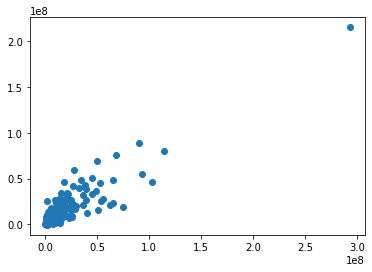

In [223]:
plt.scatter(predictions['Actual'],predictions['Predicted'])

In [224]:
get_errors(y1_test,y_pred)

(0.8081703086278922, 8393416.012027508, 3702520.174057147, 8160222.420856121)

In [225]:
CV_xgboost.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 300,
 'random_state': 12}

In [226]:
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Score - training data: 99.7 %
Score - test data: 80.8 %


    Feature Importance                                     Feature Name
11            0.253154                     PrimaryPropertyType_Hospital
4             0.211446                           PropertyGFABuilding(s)
6             0.150010                        LargestPropertyUseTypeGFA
3             0.103164                                   NumberofFloors
2             0.073426                                NumberofBuildings
1             0.039020                                        Longitude
5             0.027388                               PropertyGFAParking
7             0.025816                                   SteamUse(kBtu)
0             0.024278                                         Latitude
32            0.015696                              YearBuilt_1980_2000
30            0.011726                              YearBuilt_1940_1960
15            0.011020                 PrimaryPropertyType_Large Office
31            0.008205                              YearBuilt_19

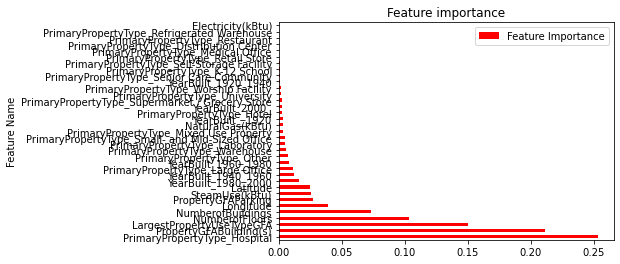

In [227]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

- <a name='C2'> LIME </a>

In [228]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [229]:
reversed_X1_train = undummify(X1_train)
reversed_X1_test =undummify(X1_test)


In [230]:
label_encoder1 = LabelEncoder().fit(reversed_X1_train['PrimaryPropertyType'])
reversed_X1_train.PrimaryPropertyType = label_encoder1.transform(reversed_X1_train['PrimaryPropertyType'])
reversed_X1_test.PrimaryPropertyType = label_encoder1.transform(reversed_X1_test['PrimaryPropertyType'])

In [231]:
label_encoder2 = LabelEncoder().fit(reversed_X1_train['YearBuilt'])
reversed_X1_train.YearBuilt = label_encoder2.transform(reversed_X1_train['YearBuilt'])
reversed_X1_test.YearBuilt = label_encoder2.transform(reversed_X1_test['YearBuilt'])

In [232]:
dict(zip(label_encoder1.classes_, label_encoder1.transform(label_encoder1.classes_)))


{'Distribution Center': 0,
 'Hospital': 1,
 'Hotel': 2,
 'K-12 School': 3,
 'Laboratory': 4,
 'Large Office': 5,
 'Medical Office': 6,
 'Mixed Use Property': 7,
 'Other': 8,
 'Refrigerated Warehouse': 9,
 'Restaurant': 10,
 'Retail Store': 11,
 'Self-Storage Facility': 12,
 'Senior Care Community': 13,
 'Small- and Mid-Sized Office': 14,
 'Supermarket / Grocery Store': 15,
 'University': 16,
 'Warehouse': 17,
 'Worship Facility': 18}

In [233]:
dict(zip(label_encoder2.classes_, label_encoder2.transform(label_encoder2.classes_)))


{'1920_1940': 0,
 '1940_1960': 1,
 '1960_1980': 2,
 '1980_2000': 3,
 '2000_': 4,
 '_1920': 5}

In [234]:
CV_xgboost.fit(reversed_X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [235]:
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(reversed_X1_train),
                                                   feature_names=reversed_X1_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [290]:
_exp = explainer.explain_instance(data_row=pd.DataFrame(reversed_X1_test).iloc[13],
                                           predict_fn=CV_xgboost.predict)

In [291]:
_exp.show_in_notebook(show_table=True)

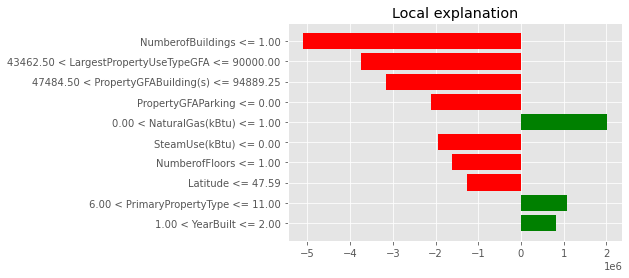

In [292]:
with plt.style.context("ggplot"):
    _exp.as_pyplot_figure()

- <a name='C2'> SHAP </a>

In [239]:
shap_model = CV_xgboost.best_estimator_
shap_explainer  = shap.TreeExplainer(shap_model,reversed_X1_train)

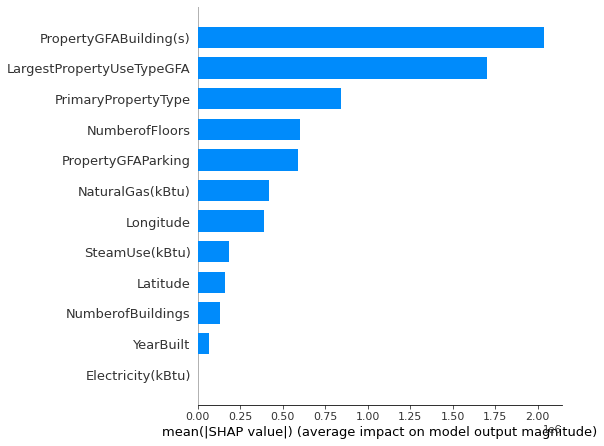

In [240]:
single_shap_value = shap_explainer(reversed_X1_test.sample(n=1))
shap.summary_plot(single_shap_value, feature_names=reversed_X1_train.columns, plot_type='bar')
plt.show()

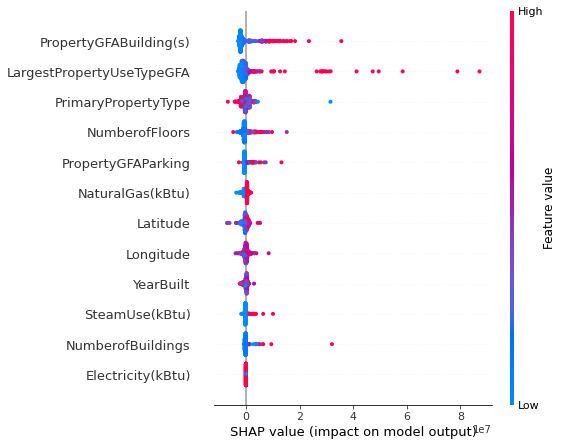

In [241]:
shap_values = shap_explainer(reversed_X1_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_X1_train.columns)
plt.show()

Le meilleur modèle choisi est le modèle <a name='C2'>*XGBoost*</a> qui sera utilisé par la suite pour la prédiction de <a name='C2'>*EnergyStarScore*</a>

## <a name='C2'> ENERGYSTARScore   </a>

In [242]:
df_EES = _df_.drop(columns='Unnamed: 0').copy()

In [243]:
features_ESS = df_EES.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

In [244]:
features_ESS_names = features_ESS.columns

In [245]:
df_EES.isna().sum()

PrimaryPropertyType            0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
ENERGYSTARScore              473
PropertyGFABuilding(s)         0
PropertyGFAParking             0
LargestPropertyUseTypeGFA      4
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
SiteEnergyUse(kBtu)            0
dtype: int64

In [246]:
df_EES = df_EES.dropna(axis=0)

In [247]:
df_EES.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
ENERGYSTARScore              0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [248]:
df_EES_encoded = pd.get_dummies(df_EES ,columns=['PrimaryPropertyType','YearBuilt'])

- Avec Energy Star Score

In [249]:
train_ESS, test_ESS = train_test_split(df_EES_encoded, test_size=0.25, random_state=10) 

In [250]:
Xe_train, ye_train, Xe_test, ye_test = train_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train_ESS["SiteEnergyUse(kBtu)"], test_ESS.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) , test_ESS["SiteEnergyUse(kBtu)"]

In [251]:
""" scaler = StandardScaler()
scaler.fit(Xe_train)
Xe_train = scaler.transform(Xe_train)
Xe_test = scaler.transform(Xe_test) """

' scaler = StandardScaler()\nscaler.fit(Xe_train)\nXe_train = scaler.transform(Xe_train)\nXe_test = scaler.transform(Xe_test) '

- Entrainement avec les meilleurs paramètres du XGBoost

In [252]:
#xGBoost_ESS = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [253]:
CV_xgboost_ESS = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_ESS.fit(Xe_train, ye_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [254]:
CV_xgboost_ESS.best_score_

0.7823261451834679

In [255]:
CV_xgboost_ESS.score(Xe_test,ye_test)

0.8105296657954159

In [256]:
model = CV_xgboost_ESS.best_estimator_

In [257]:
print(f"Validation Score: {round(CV_xgboost_ESS.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_xgboost_ESS.score(Xe_train,ye_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost_ESS.score(Xe_test,ye_test)*100,1)} %")

Validation Score: 78.2 %
Score - training data: 100.0 %
Score - test data: 81.1 %


    Feature Importance                                     Feature Name
5             0.212470                           PropertyGFABuilding(s)
7             0.197787                        LargestPropertyUseTypeGFA
2             0.179344                                NumberofBuildings
12            0.170434                     PrimaryPropertyType_Hospital
3             0.078961                                   NumberofFloors
1             0.036937                                        Longitude
6             0.032858                               PropertyGFAParking
4             0.026958                                  ENERGYSTARScore
0             0.012204                                         Latitude
15            0.011747                 PrimaryPropertyType_Large Office
28            0.005922                              YearBuilt_1960_1980
22            0.004636  PrimaryPropertyType_Small- and Mid-Sized Office
30            0.004284                                  YearBuil

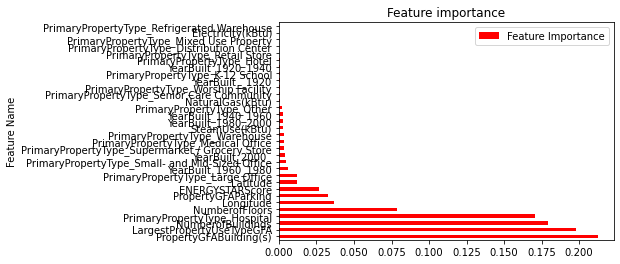

In [258]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model)

- <a name='C2'> LIME </a>

In [259]:
reversed_Xe_train = undummify(Xe_train)
reversed_Xe_test =undummify(Xe_test)

In [260]:
label_encoder3 = LabelEncoder().fit(reversed_Xe_train['PrimaryPropertyType'])
reversed_Xe_train.PrimaryPropertyType = label_encoder3.transform(reversed_Xe_train['PrimaryPropertyType'])
reversed_Xe_test.PrimaryPropertyType = label_encoder3.transform(reversed_Xe_test['PrimaryPropertyType'])

In [261]:
label_encoder4 = LabelEncoder().fit(reversed_Xe_train['YearBuilt'])
reversed_Xe_train.YearBuilt = label_encoder4.transform(reversed_Xe_train['YearBuilt'])
reversed_Xe_test.YearBuilt = label_encoder4.transform(reversed_Xe_test['YearBuilt'])

In [262]:
CV_xgboost_ESS.fit(reversed_Xe_train, ye_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [263]:
ESS_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(reversed_Xe_train),
                                                   feature_names=reversed_Xe_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [264]:
ESS_exp = ESS_explainer.explain_instance(data_row=pd.DataFrame(reversed_Xe_test).iloc[5],
                                           predict_fn=CV_xgboost_ESS.predict)

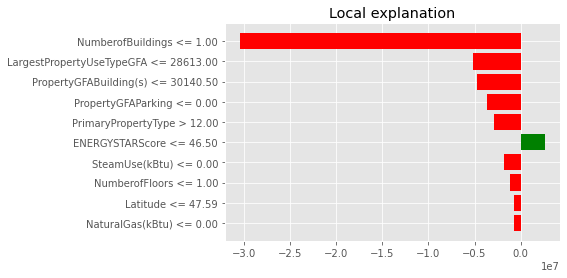

In [265]:
with plt.style.context("ggplot"):
    ESS_exp.as_pyplot_figure()

In [266]:
ESS_exp.show_in_notebook(show_table=True)

- <a name='C2'> SHAP </a>

In [267]:
ES_shap_model = CV_xgboost_ESS.best_estimator_
ES_shap_explainer  = shap.TreeExplainer(ES_shap_model,reversed_Xe_train)

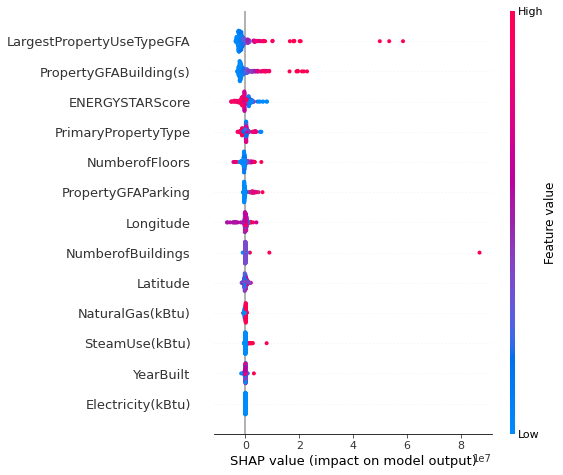

In [268]:
shap_values = ES_shap_explainer(reversed_Xe_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_Xe_train.columns)
plt.show()

- Sans Energy Star Score

In [269]:
train_S_ESS, test_S_ESS = train_test_split(df_EES_encoded, test_size=0.25, random_state=10) 

In [270]:
Xee_train, yee_train, Xee_test, yee_test = train_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']), train_S_ESS["SiteEnergyUse(kBtu)"], test_S_ESS.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)",'ENERGYSTARScore']) , test_S_ESS["SiteEnergyUse(kBtu)"]

In [271]:
""" scaler = StandardScaler()
scaler.fit(Xee_train)
Xee_train = scaler.transform(Xee_train)
Xee_test = scaler.transform(Xee_test) """

' scaler = StandardScaler()\nscaler.fit(Xee_train)\nXee_train = scaler.transform(Xee_train)\nXee_test = scaler.transform(Xee_test) '

In [272]:
#xGBoost_S_ESS = GradientBoostingRegressor(**CV_xgboost_ESS.best_params_)

In [273]:
#xGBoost_S_ESS.fit(Xee_train,yee_train)

In [274]:
CV_xGBoost_S_ESS = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xGBoost_S_ESS.fit(Xee_train, yee_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [275]:
CV_xGBoost_S_ESS.best_score_

0.758010397026233

In [276]:
CV_xGBoost_S_ESS.score(Xee_test,yee_test)

0.7937145751758778

In [277]:
print(f"Validation Score: {round(CV_xGBoost_S_ESS.best_score_*100,1)} %")
print(f"Score - training data: {round(CV_xGBoost_S_ESS.score(Xee_train,yee_train)*100,1)} %")
print(f"Score - test data: {round(CV_xGBoost_S_ESS.score(Xee_test,yee_test)*100,1)} %")

Validation Score: 75.8 %
Score - training data: 100.0 %
Score - test data: 79.4 %


    Feature Importance                                     Feature Name
6             0.308994                        LargestPropertyUseTypeGFA
11            0.189535                     PrimaryPropertyType_Hospital
4             0.156961                           PropertyGFABuilding(s)
2             0.093987                                NumberofBuildings
3             0.061016                                   NumberofFloors
1             0.046731                                        Longitude
0             0.036511                                         Latitude
5             0.021515                               PropertyGFAParking
7             0.017888                                   SteamUse(kBtu)
14            0.017885                 PrimaryPropertyType_Large Office
27            0.009882                              YearBuilt_1960_1980
29            0.006204                                  YearBuilt_2000_
30            0.004642                                  YearBuil

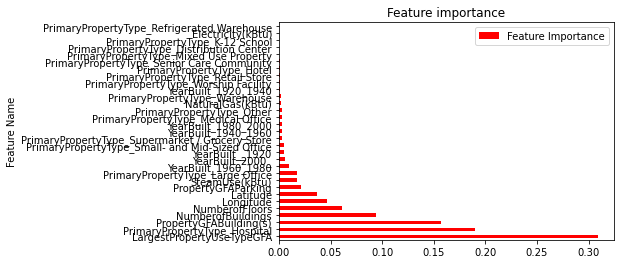

In [278]:
def display_feat_imp_xgboost(boosted):
  feat_imp = CV_xGBoost_S_ESS.best_estimator_.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xee_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(CV_xGBoost_S_ESS.best_estimator_)

- <a name='C2'> LIME </a>

In [279]:
reversed_Xee_train = undummify(Xee_train)
reversed_Xee_test =undummify(Xee_test)

In [280]:
label_encoder5 = LabelEncoder().fit(reversed_Xee_train['PrimaryPropertyType'])
reversed_Xee_train.PrimaryPropertyType = label_encoder5.transform(reversed_Xee_train['PrimaryPropertyType'])
reversed_Xee_test.PrimaryPropertyType = label_encoder5.transform(reversed_Xee_test['PrimaryPropertyType'])

In [281]:
label_encoder6 = LabelEncoder().fit(reversed_Xee_train['YearBuilt'])
reversed_Xee_train.YearBuilt = label_encoder6.transform(reversed_Xee_train['YearBuilt'])
reversed_Xee_test.YearBuilt = label_encoder6.transform(reversed_Xee_test['YearBuilt'])

In [282]:
CV_xGBoost_S_ESS.fit(reversed_Xee_train, yee_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [283]:
S_ESS_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(reversed_Xee_train),
                                                   feature_names=reversed_Xee_train.columns,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [294]:
#idx = random.randint(1, len(reversed_Xee_test))

S_ESS_exp = S_ESS_explainer.explain_instance(data_row=pd.DataFrame(reversed_Xee_test).iloc[1],
                                           predict_fn=CV_xGBoost_S_ESS.predict)

S_ESS_exp.show_in_notebook(show_predicted_value=False)


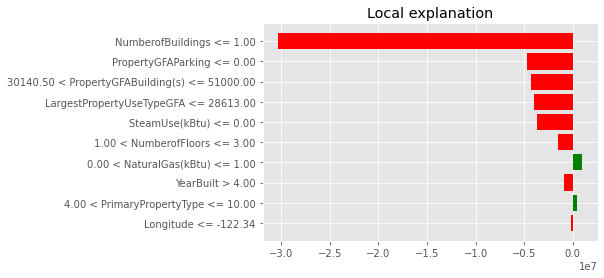

In [295]:
with plt.style.context("ggplot"):
    S_ESS_exp.as_pyplot_figure()

- <a name='C2'> SHAP </a>

In [286]:
SES_shap_model = CV_xGBoost_S_ESS.best_estimator_
SES_shap_explainer  = shap.TreeExplainer(SES_shap_model,reversed_Xee_train)

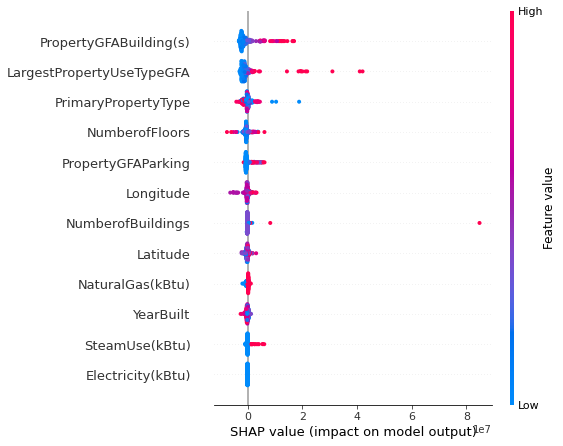

In [287]:
shap_values = SES_shap_explainer(reversed_Xee_test,check_additivity = False)
shap.summary_plot(shap_values, feature_names=reversed_Xee_train.columns)
plt.show()